## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Филимонов Степан Владиславович

In [34]:
import os
import warnings
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from torch import no_grad, max, device, cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")
print(DEVICE)

cpu


## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

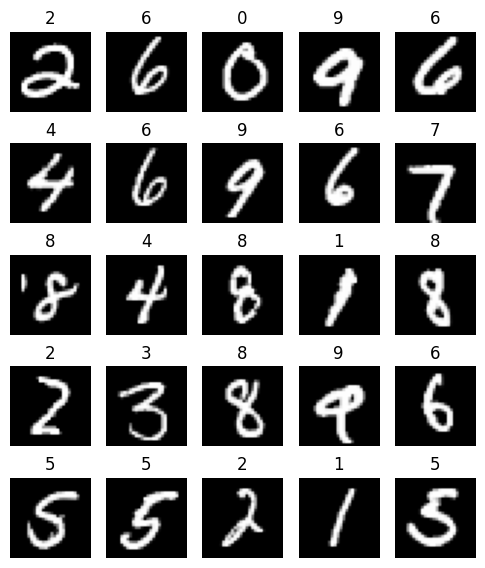

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [7]:
forward_lst = []
backward_lst = []

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    forward_lst.append(std)
    #print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    backward_lst.append(std)
    #print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [9]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [10]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### На будущее

In [47]:
def train(network, epochs, learning_rate):
    global DEVICE, train_loader, test_loader
    
    def _epoch(network, loss, loader, backward=True, optimizer=None):
        losses = []
        accuracies = []
        for X, y in loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            network.zero_grad()
            prediction = network(X)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.cpu().item())
            if backward:
                loss_batch.backward()
                optimizer.step()
            prediction = prediction.max(1)[1]
            accuracies.append((prediction==y).cpu().float().numpy().mean())
        return losses, accuracies

    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(DEVICE)

    for epoch in range(epochs):
        network.train()
        losses, accuracies = _epoch(network, loss, train_loader, True, optimizer)
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        network.eval()
        losses, accuracies = _epoch(network, loss, test_loader, False, optimizer)

        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
        clear_output(True)
        print(
            'Epoch [{0}/{1}] (Train/Test) Loss: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f}'.format(
            (epoch+1), (epochs), train_loss_epochs[-1], test_loss_epochs[-1], train_accuracy_epochs[-1],
            test_accuracy_epochs[-1])
        )

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs, label='Train')
        plt.plot(test_loss_epochs, label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_epochs, label='Train accuracy')
        plt.plot(test_accuracy_epochs, label='Test accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

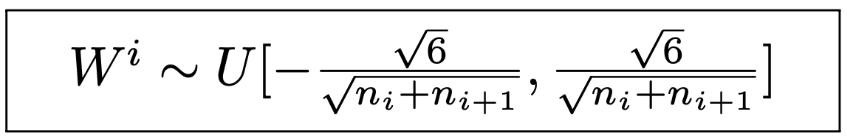

In [14]:
class Xavier:
    def __call__(self, layer, size_input, size_output):
        weight = layer.state_dict()['weight']
        bias = layer.state_dict()['bias']
        bias.zero_()
        a_range = np.sqrt(6 / (size_input + size_output))
        weight.uniform_(-a_range, a_range)

xavier = Xavier()

In [15]:
sizes = [ 28 * 28, 32, 16] + [16] * 10 + [10]

In [16]:
layers_xavier = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer_xavier = nn.Linear(size_input, size_output)
    layer_xavier.register_forward_hook(forward_hook)
    layer_xavier.register_backward_hook(backward_hook)

    xavier(layer_xavier, size_input, size_output)

    layers_xavier.append(layer_xavier)
    layers_xavier.append(nn.Tanh())

print(f'Колличество слоев: {len(layers_xavier)}')
forward_lst.clear()
backward_lst.clear()

Колличество слоев: 26


In [17]:
network = nn.Sequential(*layers_xavier)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

In [18]:
lst_xavier_forward = forward_lst.copy()
lst_xavier_backward = backward_lst.copy()

#### He

In [19]:
class He:
    def _forward(self, size_input, size_output):
        return np.sqrt(2 / size_input)

    def _backward(self, size_input, size_output):
        return np.sqrt(2 / size_output)
        
    def __call__(self, layer, mean=0, std=1):
        weight = layer.state_dict()['weight']
        bias = layer.state_dict()['bias']
        bias.zero_()
        weight.normal_(mean=mean, std=std)

he = He()

In [20]:
layers_he = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer_he = nn.Linear(size_input, size_output)
    layer_he.register_forward_hook(forward_hook)
    layer_he.register_backward_hook(backward_hook)

    he(layer_he, 0, std=he._backward(size_input, size_output))

    layers_he.append(layer_he)
    layers_he.append(nn.ReLU())

print(f'Колличество слоев: {len(layers_he)}')
forward_lst.clear()
backward_lst.clear()

Колличество слоев: 26


In [21]:
network = nn.Sequential(*layers_he)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

In [22]:
lst_he_forward = forward_lst.copy()
lst_he_backward = backward_lst.copy()

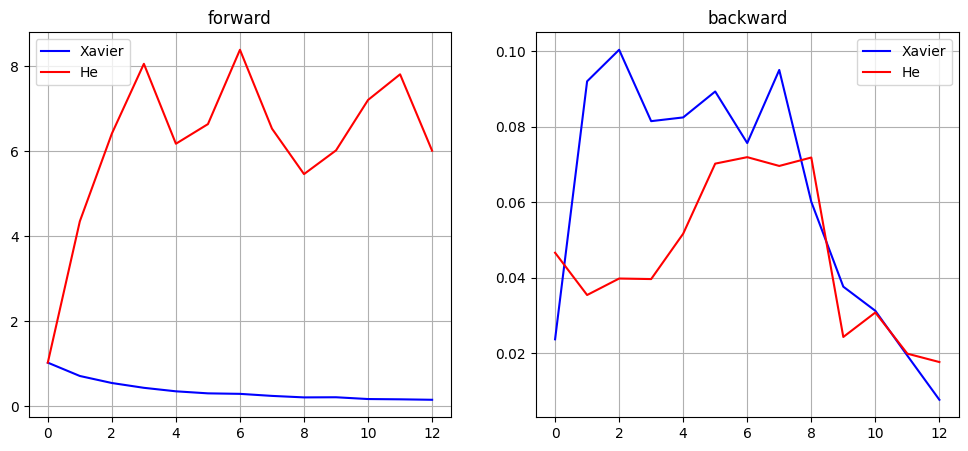

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lst_xavier_forward, 'b', label='Xavier')
plt.plot(lst_he_forward, 'r', label='He')
plt.grid()
plt.legend()
plt.title('forward')
plt.subplot(1, 2, 2)
plt.plot(lst_xavier_backward, 'b', label='Xavier')
plt.plot(lst_he_backward, 'r', label='He')
plt.title('backward')
plt.legend()
plt.grid()
plt.show()

**Вывод:**
1. *Xavier* показывает инициализацию лучше чем *He*

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

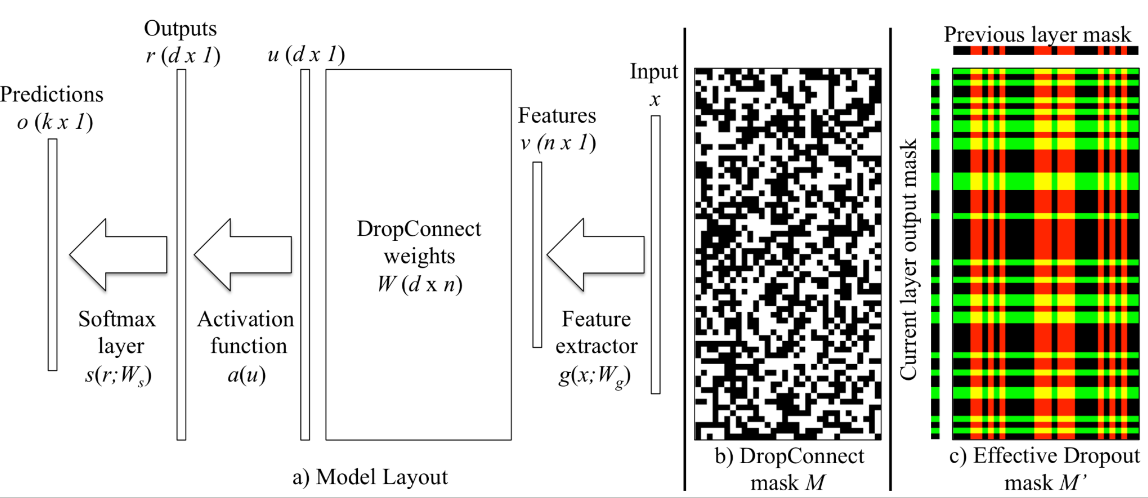

In [24]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:
            mask = mask.bernoulli_(self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [25]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями

In [51]:
layers_drop_out = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10)
]

In [52]:
network_drop_out = TestNetwork(nn.Sequential(*layers_drop_out))

Epoch [10/10] (Train/Test) Loss: 0.142/0.071, Accuracy: 0.958/0.977


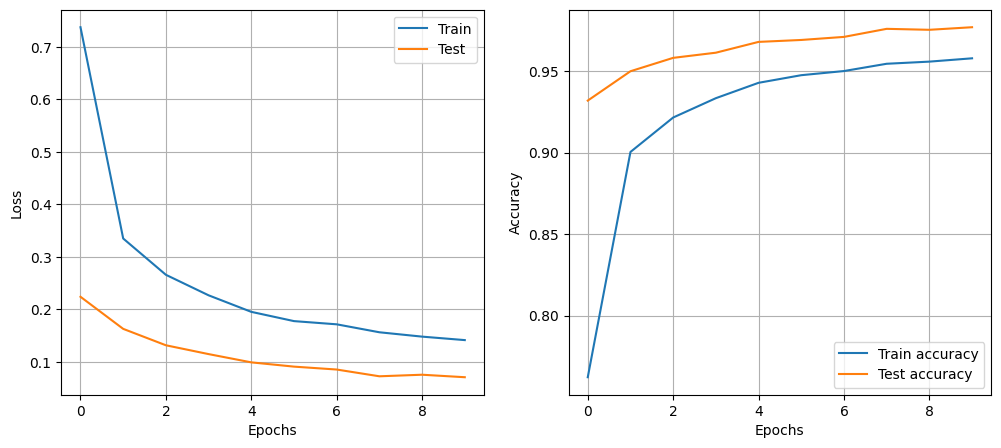

CPU times: user 5min 5s, sys: 46.3 s, total: 5min 51s
Wall time: 1min


In [53]:
%%time
train(network_drop_out, 10, 0.001)

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев

In [54]:
layers_drop_connect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

In [55]:
network_drop_connect = TestNetwork(nn.Sequential(*layers_drop_connect))

Epoch [10/10] (Train/Test) Loss: 0.183/0.096, Accuracy: 0.943/0.970


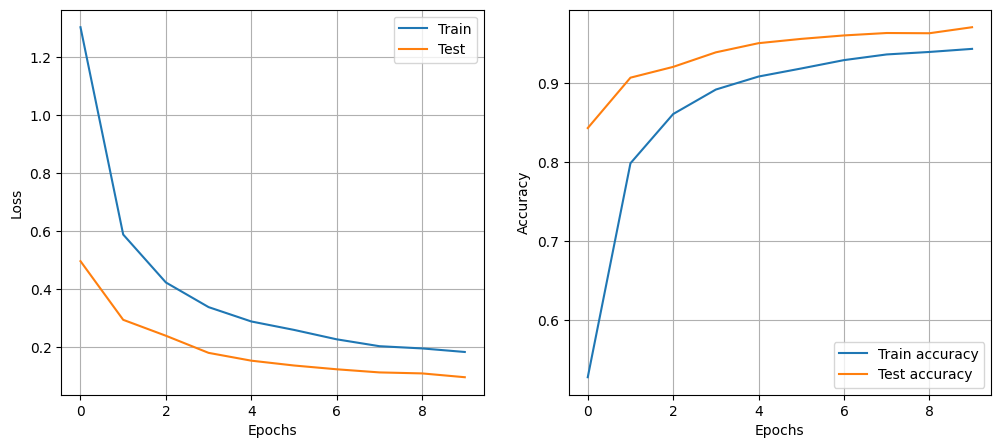

CPU times: user 5min 8s, sys: 45.2 s, total: 5min 53s
Wall time: 1min


In [56]:
%%time
train(network_drop_connect, 10, 0.001)

**Вывод:**
1. У Dropout метрика accuracy лучше
2. Значение на тестовой выборки лучше чем на тренировочной

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

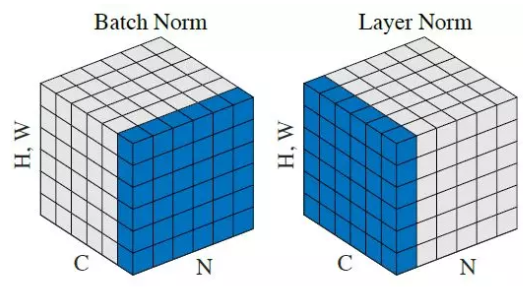

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [57]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self._alpha = nn.Parameter(torch.ones(dim))
        self._beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        return ( self._alpha * ( x - x.mean() ) / x.std() + self._beta )

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:

1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями

In [58]:
layers_batch = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [59]:
network_batch = TestNetwork(nn.Sequential(*layers_batch))

Epoch [10/10] (Train/Test) Loss: 0.018/0.057, Accuracy: 0.994/0.982


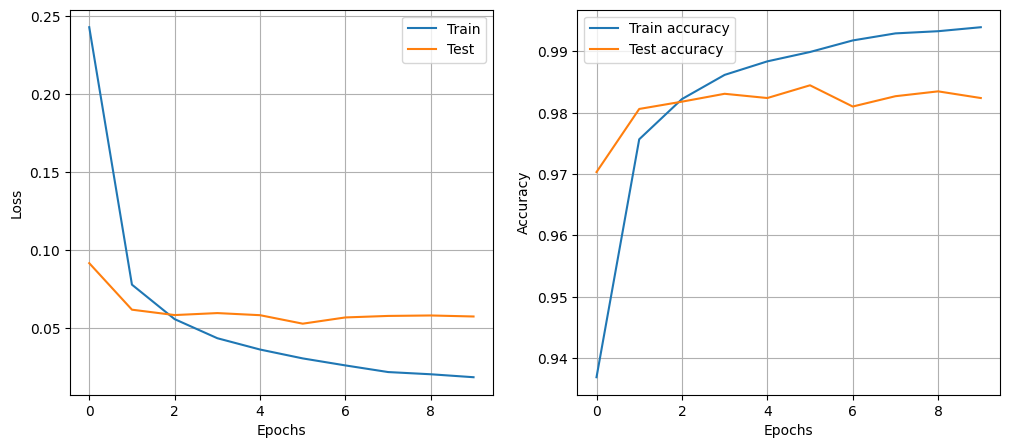

CPU times: user 6min 6s, sys: 1min 5s, total: 7min 11s
Wall time: 1min 14s


In [60]:
%%time
train(network_batch, 10, 0.001)

2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [62]:
layers_layer = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [64]:
network_layer = TestNetwork(nn.Sequential(*layers_layer))

Epoch [10/10] (Train/Test) Loss: 0.028/0.059, Accuracy: 0.991/0.981


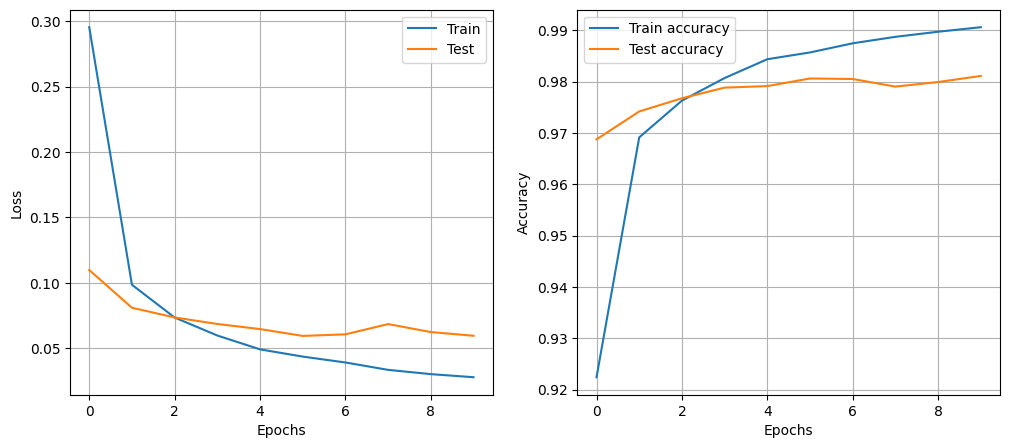

CPU times: user 6min 7s, sys: 1min 12s, total: 7min 19s
Wall time: 1min 16s


In [65]:
%%time
train(network_layer, 10, 0.001)

**Вывод:**
1. В целом оба метода +- одинаковые
2. Но при этом отчетиливо видно, что accuracy на тестовой выборке вышла на плато